**DA5401: Assignment 5**

*Visualising Data Veracity Challenges in Multi-Label Classification*

Submitted by: **Devashish Tripathi**

Roll Number: **DA25C006**

### Problem Statement

Utilising t-SNE and Isomap, inspect data to expose issues such as Ambiguous or Noisy Labels, Outliers and Hard-to-Learn Samples, showcasing the data veracity and the challenges a classifier would face.

**Imports**

In [1]:
# To allow importing the arff file format the dataset is in
from scipy.io import arff

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
# Scikit-Learn Imports
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import StandardScaler

# Setting random seed
random_state = 66

**Function to aid in visualisation**

In [120]:
def plot_scatter(projection, labels, const, kind= 't-SNE'):
    unique_labels = np.unique(labels)
    markers = ['o', 's', '*', 'x']

    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    label_to_marker = {label: markers[idx] for idx, label in enumerate(unique_labels)}

    colours = np.array(sns.color_palette('colorblind', len(unique_labels)))
    
    title = f'{kind} visualisation for {const}'
    
    plt.figure(figsize=(8, 8))
    handles = []
    for label, idx in label_to_id.items():
        mask = (labels == label)
        marker_shape = label_to_marker[label]
        marker_color = colours[idx]
        
        plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,
            color=marker_color, label=label, lw=1, edgecolors='black', alpha= 0.7
        )
        handles.append(plt.Line2D([], [], marker=marker_shape, color=marker_color, linestyle="", 
                                  markersize=10, label=label))

    plt.legend(handles=handles, title="Classes", loc='best')
    plt.tight_layout()
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

## Part A: Preprocessing and Initial Setup

**Data Loading**

In [3]:
data, meta = arff.loadarff("yeast.arff")
df = pd.DataFrame(data)
display(df.head())

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [113]:
# Separating the dataframe into the features and the labels
attributes = [col for col in df.columns if 'Att' in col]
X = df[attributes]
y = df.drop(attributes, axis= 1).astype(int)

**Dimensionality Check**

In [114]:
print("Initial Number of Features:", X.shape[1])
print("Initial Number of Labels:", y.shape[1])
print("All Possible Labels:", np.unique(y))
print("Number of Data Points:", df.shape[0])

Initial Number of Features: 103
Initial Number of Labels: 14
All Possible Labels: [0 1]
Number of Data Points: 2417


**Label Selection for Visualisation**

Creating a new target label to represent the *two-most frequent single-label classes* and the *most frequent multi-label combination*, while assigning 'Other' to the rest

In [126]:
# All 14 label categories take only two values, 0 and 1
# Finding single-label rows and top-2 columns with highest frequencies


single_label_rows = y[y.sum(axis= 1) == 1]
count_labels = single_label_rows.sum(axis=0).sort_values(ascending=False)
label1, label2 = count_labels.index[:2]

# Finding the rows with multi-label combination and then the most common combination
multi_label_rows = y[y.sum(axis= 1) > 1]
multi_counts = y.apply(lambda row: tuple(row[row==1].index), axis= 1).value_counts()
label3 = multi_counts.index[0]

def map_labels(row):
    if row.sum() == 1:
        if row[label1] == 1:
            return 'Label_1'
        elif row[label2] == 1:
            return 'Label_2'
    elif row.sum() > 1 and tuple(row[row==1].index) == label3:
        return 'Label_3'
    else:
        return 'Other'

y_new = y.apply(map_labels, axis= 1)
print(y_new.value_counts())


Other      2148
Label_3     237
Label_1      32
Name: count, dtype: int64


*When defining single-label classes as those classes which contain only one label, it appears that there are only 32 such examples in the whole dataset, wherein all those examples appear to belong to the same class as out of the two Labels designed for single-class, only one appears, which means instead of getting four categorical labels, we instead get only three. As such, the categorisation method is slightly modified below, where the categories are now instead the top single class label and the top-two multi-class label, along with Others*

In [128]:
count_labels = single_label_rows.sum(axis=0).sort_values(ascending=False)
label1 = count_labels.index[0]

multi_label_rows = y[y.sum(axis= 1) > 1]
multi_counts = y.apply(lambda row: tuple(row[row==1].index), axis= 1).value_counts()
label2, label3 = multi_counts.index[:2]

def map_labels(row):
    if row.sum() == 1:
        if row[label1] == 1:
            return 'Label_1'
    elif tuple(row[row==1].index) == label2:
        return 'Label_2'
    elif tuple(row[row==1].index) == label3:
        return 'Label_3'
    else:
        return 'Other'

y_new = y.apply(map_labels, axis= 1)
print(y_new.value_counts())

Other      1915
Label_2     237
Label_3     233
Label_1      32
Name: count, dtype: int64


**Scaling**

*For distance-based methods such as t-SNE, it is necessary to scale the data in order to prevent the bias towards higher distances. As there are multiple features available, they all might be at different scales, and as such, some feature in a smaller range would exhibit lower distances as compared to another having a larger range. As such, scaling would ensure all the features are on the same scale and have equal weight in distance calculation, and thus providing meaningful t-SNE visualisation.*

In [117]:
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

## Part B: t-SNE and Veracity Inspection

**t-SNE Implementation**

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


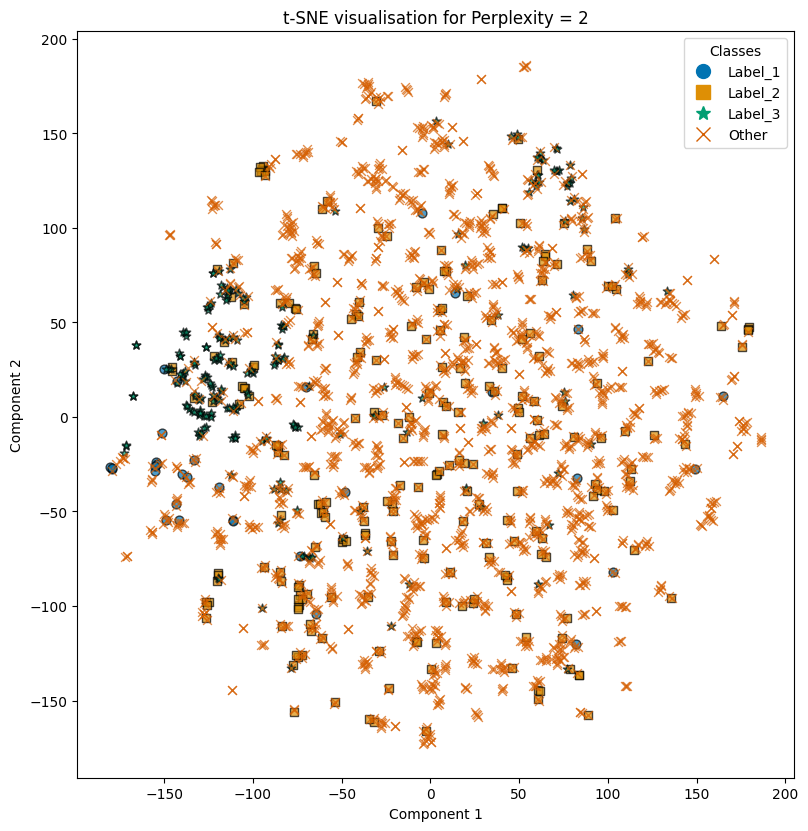

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


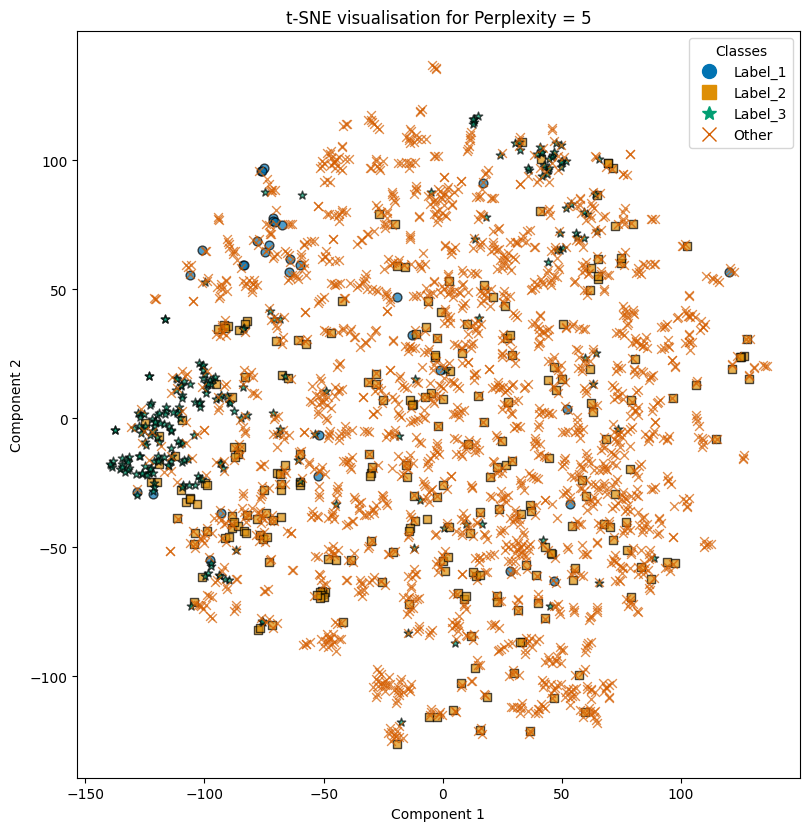

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


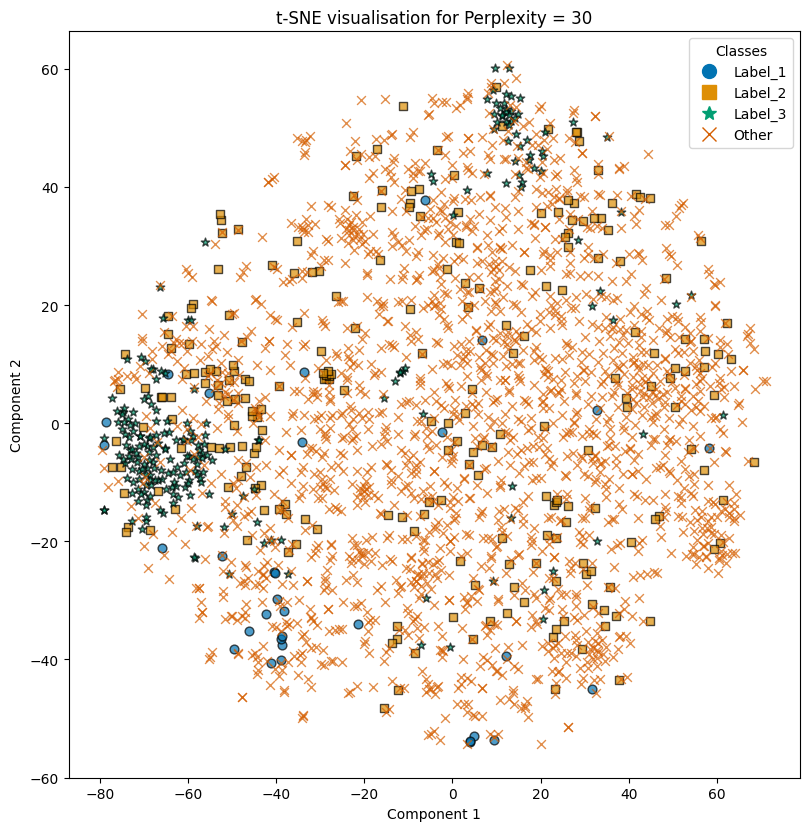

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


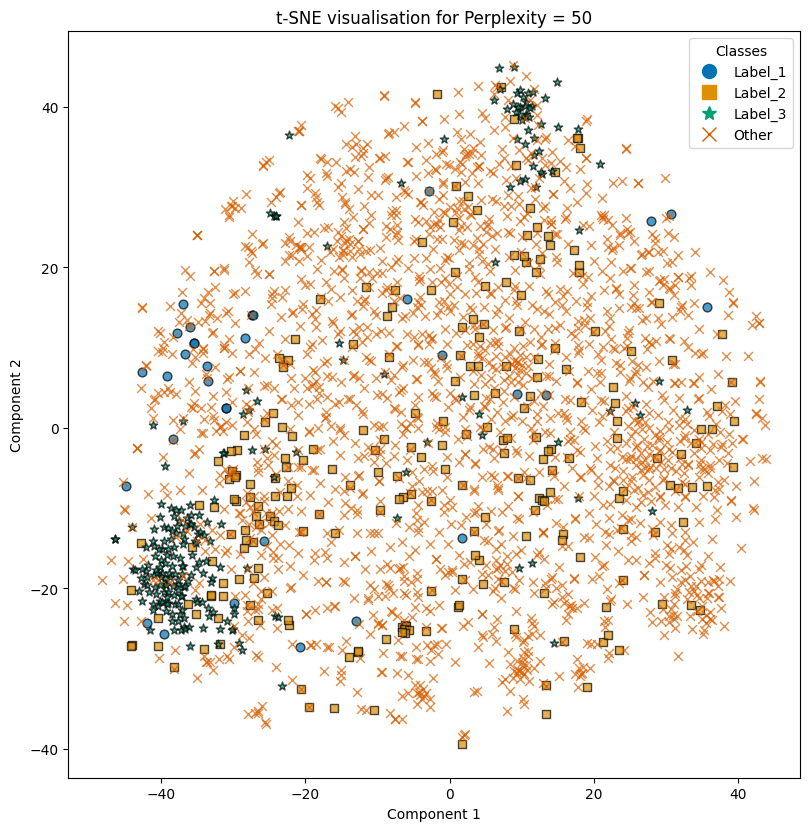

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


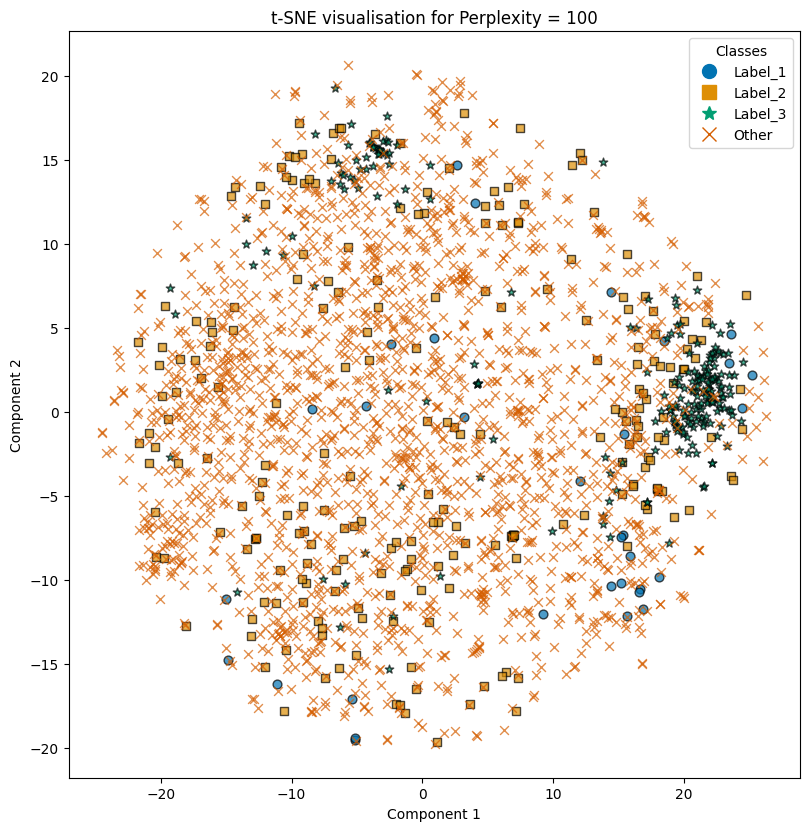

In [121]:
# experimenting with perplexity values. 
# values taken from Wattenberg, et al., "How to Use t-SNE Effectively", Distill, 2016. http://doi.org/10.23915/distill.00002

perplexities = [2, 5, 30, 50, 100]
for perp in perplexities:
    tsne_projection = TSNE(n_components= 2, random_state= random_state, max_iter= 5000, perplexity= perp).fit_transform(X_new)
    plot_scatter(tsne_projection, y_new, f'Perplexity = {perp}')

*The various perplexity values tried were taken from Wattenberg, et al., "How to Use t-SNE Effectively", Distill, 2016. http://doi.org/10.23915/distill.00002.*

*None of them are able to cleanly separate out the clusters. In fact, all of them showcase some common features. In all of them, Label 3 points are grouped together in two clusters, and the 'Others' points overwhelm the entire map, though that is also due to the fact that Others has the highest amount of datapoints. This indicates the data is not separable enough in the first two dimensions, and more dimensions are needed to get some meaningful information. Additionally, the approach by which we have decided our class categorisation also plays a role, wherein most points are given to the 'others' class. For a dataset like this, where there are 2^14 possible combinations of labels, more multi-label combinations should be used.*

*For our case, we go with the default perplexity value of 30. The original work on t-SNE (Maaten and Hinton, "Visualizing Data using t-SNE", JMLR, 2008. https://www.jmlr.org/papers/v9/vandermaaten08a.html.) recommends a value within the 5-50 range, and 30 lies in this range, striking a balance between weighing closer points more while still considering farther points without ignoring them. For Perplexity= 30, we also see points of Label 1 as the most apparent, wherein in other values, they are either overshadowed by the other categories, or are too spread out to have any meaning.*

**Visualisation of final t-SNE results**

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


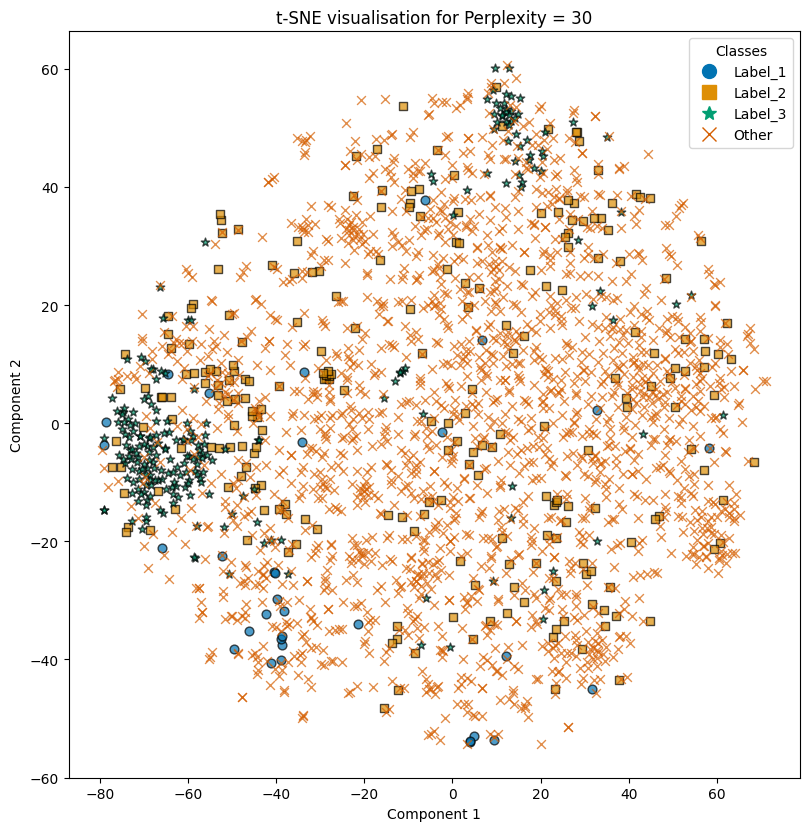

In [122]:
tsne_projection = TSNE(n_components= 2, random_state= random_state, max_iter= 5000, perplexity= 30).fit_transform(X_new)
plot_scatter(tsne_projection, y_new, f'Perplexity = {30}')

*In order to confirm whether the hypothesis of the data having not linearly separable clusters in lower dimensions for our categorisation method, applying PCA*

Explained Variance Ratio: 0.9534954856172797
Explained Variance Ratio for top-2 components: 0.1745402028418373


/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


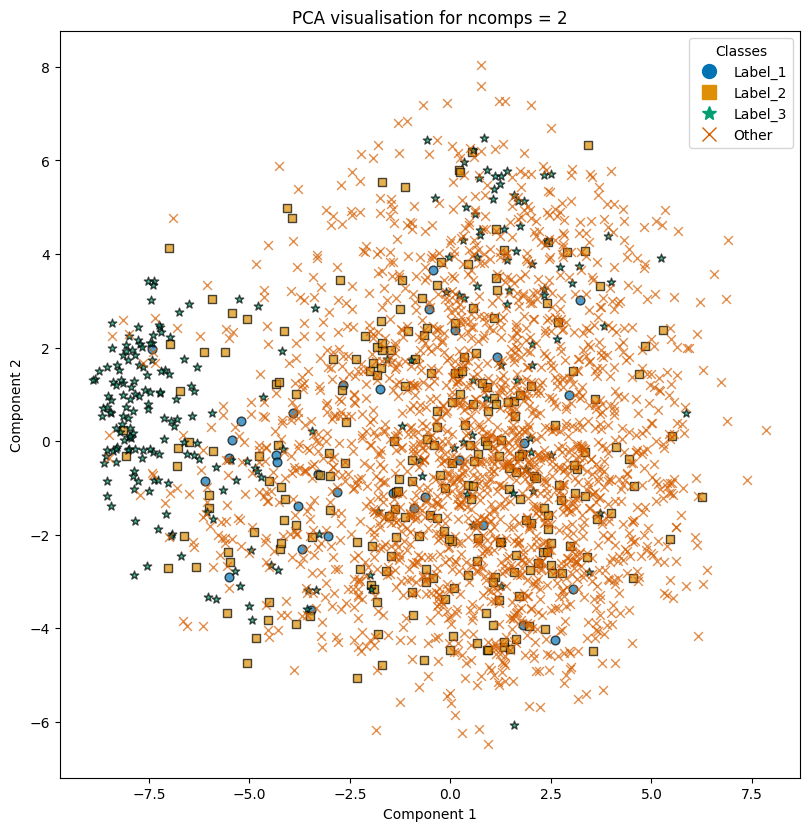

In [123]:
from sklearn.decomposition import PCA

pca = PCA(n_components=75)
pca_proj = pca.fit_transform(X_new)
print("Explained Variance Ratio:", sum(pca.explained_variance_ratio_))
print("Explained Variance Ratio for top-2 components:", sum(pca.explained_variance_ratio_[:2]))
plot_scatter(pca_proj, y_new, 'ncomps = 2', 'PCA')

*As can be seen, it takes about 75 of the 103 components to explain 95% of the variance, indicating severe non-linearity. The top-2 components end up explaining only 17% of the variance, explaining why we do not get any meaningful clusters.*

### Veracity Inspection

*Veracity means the goodness and quality of data. Higher veracity would mean better quality data. Veracity is hurt by the presence of outliers, noisy labels and hard-to-learn samples, i.e when samples are not linearly separable. In this dataset, analysing the t-SNE plot*

**Noisy/Ambiguous Labels:** *These are points where one color is deeply embedded within a cluster of a different color. The way we have categorised the data, the 'Others' Class covers the whole space, meaning there are samples here which might be interfering with meaningful combinations can be seen by the overlap of 'Others' with Label 3 in the top area of the graph. However, the way we determine the noisiness of samples is based on their categorisation, and a categorisation which might have ended up without these many points belong to the 'Others' class would have had lesser number of such points. As of this categorisation, the 'Others' class contains several noisy points, which might include samples which have unique label combinations not shared with anyother sample, and thus, being totally unique.* 

**Outliers:** *While some Label 1 points and many Label 3 points cluster around on the left side of the space, a vast majority of each do not. Whereas Label 2 is spread all throughout the space along with 'Others', a few Label 3 points do begin to cluster on the top, but not cluster completely. This tiny cluster is far away from the apparent main cluster, and could be considered as an outlier. There are also several points of the 'Others' class which are quite distant from the dense, centre region and do not exhibit any clustering in of themselves, indicating these might be those unique labelled points, and thus, could also be considered as outliers. In case of the tiny-cluster of Label 3, it might indicate the presence of points with similar identity but wrong categorisation.*

**Hard-to-Learn Samples:** *Not counting the spread of the 'Others' class, along the centre of the map, the three labels show heavy mixing throughout the space, particularly at the dense centre, making this a hard-to-learn problem, particularly for simple classifiers, as these classifiers tend to perform well when the data is linearly separable, which it is clearly not in this case.*


## Part C: Isomap and Manifold Learning

**Isomap Implementation**

*Isomaps focus on preserving the global structure of the data. It assumes that the high-dimensional data lies on a low-dimensional manifold which captures all the non-linearity in the data. It considers the distance between the individual points as the factor which must remain same, inspite of the operation applied on the manifold. As such, it tries to flatten the manifold so that the distances in the low-dimensional embedding are preserved and reflect the same in the higher dimensional space.*

*On the other hand, t-SNE is designed to preserve local structure. It works by keeping similar data points in the higher dimensioal space, i.e., neighbours close in the mapping and dissimilar data points as far awar as possible in the mapping. As the focus is on keeping the local structure, global details might be missed or wrongly indicated*

**Visualisation**

/tmp/ipykernel_1243/3819356697.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(projection[mask, 0], projection[mask, 1], marker=marker_shape, s=40,


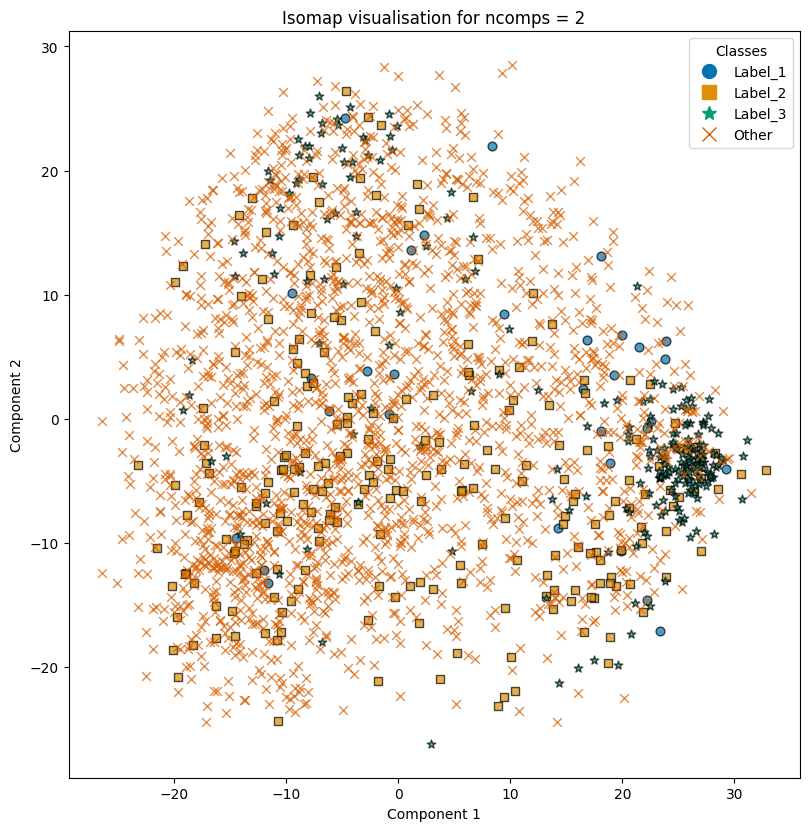

In [129]:
model = Isomap(n_components= 2)
iso_projection = model.fit_transform(X_new)
plot_scatter(iso_projection, y_new, 'ncomps = 2', 'Isomap')

### Comparison and Curvature

**Which is better for global structure? Isomap or t-SNE?**

*Isomaps are better at preserving global structure. They compute Manifold distance between all pairs of points and aim to preserve these while transforming to lower dimensions, while t-SNE focuses on maintaining local strucuture, which might end up distorting the global structure, meaning while it might preserve local clusters, it won't preserve their connections with each other.*

**Data Manifold:** *A Data Manifold represents a lower dimensional surface on which the high dimensional data lies i.e. any high dimensional data might actually be approximated as low-dimensional if its manifold is known.*

*The Isomap suggests a highly complex manifold. Using t-SNE and PCA, it had been determined that the data is very high dimensional. That, along with the category wise clusters here, where like in t-SNE, only Label-3 is still grouped together in two clusters, one small and one large indicates, while the rest are scattered throughout indicates severe non-linearity for the manifold. For such a manifold, where the features would be non-linear and intermixed, classifiers which rely on linear boundaries would not be able to find good boundaries, leading to poor classification results.*

**Conclusion**

*Thus, we can conclude that the Yeast dataset lies in a high dimensional manifold which is non-linear and has the datapoints and features intertwined. Through t-SNE, PCA and Isomap, it can be confirmed that the dataset is not linearly separable in lower dimensions. The categorisation method used also plays a role and suitable categorisation is needed, accounting not only all the features present, but also the non-linearity and the high-dimensional manifold. As such, we can confirm that this dataset would pose as a hard classification problem for a simple classifier*

**References:**

*[1] "How to Use t-SNE Effectively", Distill, 2016. http://doi.org/10.23915/distill.00002.*

*[2] Maaten and Hinton, "Visualizing Data using t-SNE", JMLR, 2008. https://www.jmlr.org/papers/v9/vandermaaten08a.html*



## Appendix

Using more than four categories to see if the clustering improves

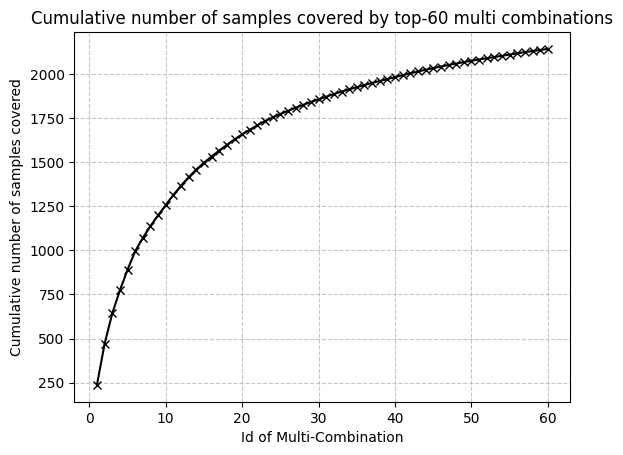

In [99]:
multi_label_rows = y[y.sum(axis= 1) >= 1]
multi_counts = y.apply(lambda row: tuple(row[row==1].index), axis= 1).value_counts()

## considering the multi-counts are arranged in descending order, evaluating number of combos coverered
## the top-60 of them

plt.figure()
plt.plot(range(1, 61), np.cumsum(multi_counts[:60]), '-xk')
plt.grid(alpha = 0.7, linestyle='--')
plt.title('Cumulative number of samples covered by top-60 multi combinations')
plt.xlabel('Id of Multi-Combination')
plt.ylabel('Cumulative number of samples covered')
plt.show()

*Around top-40 combinations cover most of the data, however, the curve has an elbow at around top-20 combinations. Going with that...*

In [130]:
top_combos = multi_counts.index[:20]

# Build mapping dictionary
combo_to_label = {combo: f'Label_{i+1}' for i, combo in enumerate(top_combos)}

def map_labels(row):
    combo = tuple(row[row == 1].index)
    return combo_to_label.get(combo, 'Other')

# Apply to all rows
y_new = y.apply(map_labels, axis=1)

print(f"Total categories: {y_new.nunique()}")


Total categories: 21


*Going with the same perplexity value of 30 for doing t-SNE*

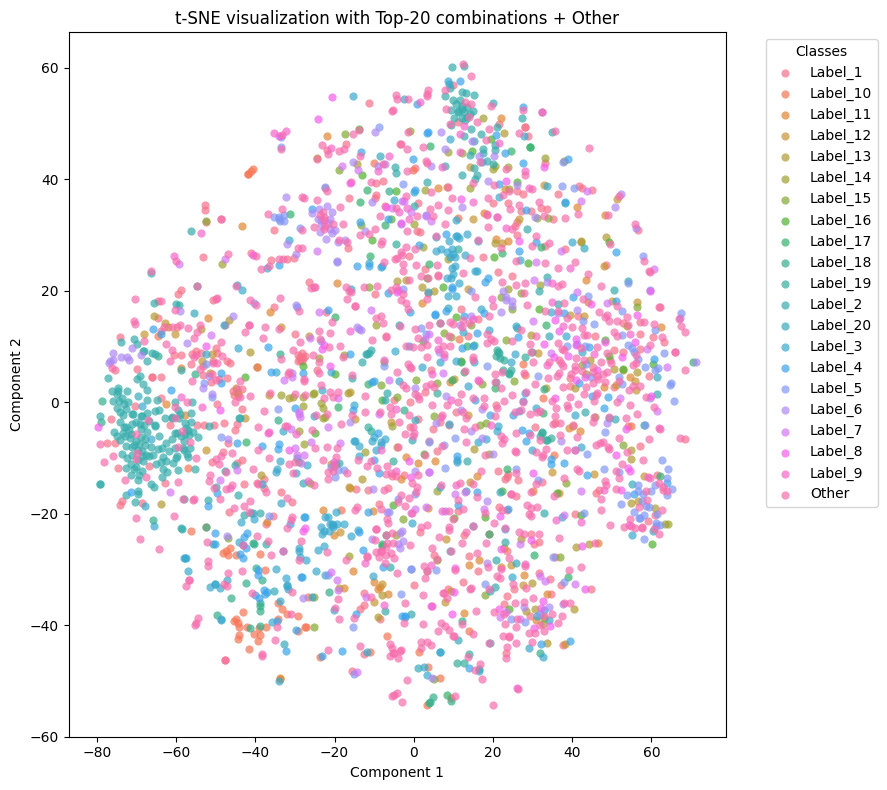

In [125]:
perp = 30
tsne_projection = TSNE(n_components= 2, random_state= random_state, max_iter= 5000).fit_transform(X_new)
unique_labels = np.unique(y_new)
num_labels = len(unique_labels)
palette = sns.color_palette('husl', num_labels)
color_map = {lab: palette[i % len(palette)] for i, lab in enumerate(unique_labels)}

plt.figure(figsize=(9, 8))
for label in unique_labels:
    mask = (y_new == label)
    plt.scatter(
        tsne_projection[mask, 0],
        tsne_projection[mask, 1],
        s=35, c=[color_map[label]], label=label, alpha=0.7, lw=0
    )

plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE visualization with Top-20 combinations + Other")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()


*Even when considering higher number of combinations as categories, it is evident that the data is not linearly separable, as the 'Others' class samples are still spread throughout the space. Taking any more number of combinations would mean that for any standard classifier, we are making it learn the outliers, thus reducing its generalisability, as the number of samples belonging to each label decreases, as seen in the cumulative sum plot earlier. This along with the PCA variance ratio earlier indicates that not only is there a need of a better categorisation method, but also this data resides in a very high dimensional manifold, and any classification would have to be done there.*

*Evaluating the same on Isomaps to see if any change is reflected there*

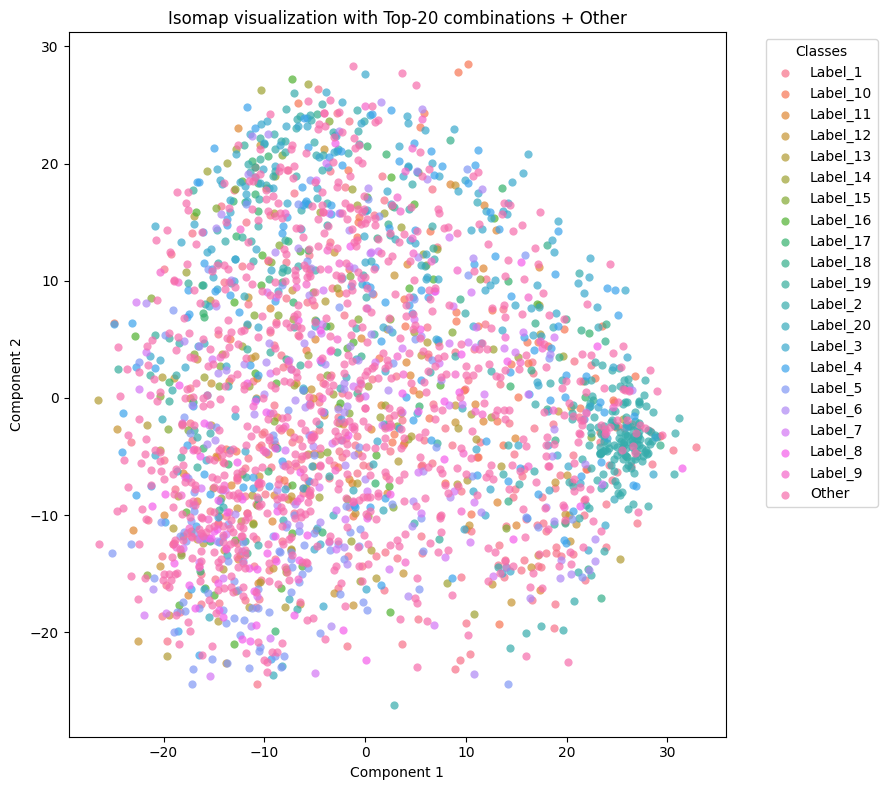

In [132]:
model = Isomap(n_components= 2)
iso_projection = model.fit_transform(X_new)

unique_labels = np.unique(y_new)
num_labels = len(unique_labels)
palette = sns.color_palette('husl', num_labels)
color_map = {lab: palette[i % len(palette)] for i, lab in enumerate(unique_labels)}

plt.figure(figsize=(9, 8))
for label in unique_labels:
    mask = (y_new == label)
    plt.scatter(
        iso_projection[mask, 0],
        iso_projection[mask, 1],
        s=35, c=[color_map[label]], label=label, alpha=0.7, lw=0
    )

plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Isomap visualization with Top-20 combinations + Other")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

*We see similar results as in earlier cases, indicating that the data is extremely non-linear and requires not only robust categorisation, but also a higher dimensional non-linear classifier for classification*